# 1. Import packages

In [1]:
import os
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import logging 

In [2]:
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# 2. Data loading

## 2.1. Dataset description

### A toy dataset
- **Triangular** currency pairs: `gbpusd`, `usdjpy`, **`jpygbp`**
  - $\frac{USD}{GBP}\times\frac{JPY}{USD}\times\frac{GBP}{JPY}=1$. Therefore, the following holds assuming a frictionless market condition:
  - $\log{\frac{USD}{GBP}}-\log{\frac{JPY}{USD}}-\log{\frac{GBP}{JPY}}=0.$
- Period: One day. May 1st, 2019.
- Frequency: 1 minute (=1440 data points per day per currency pair)

## 2.2 Loading a toy data set

In [3]:
toy_path = '../dataset/'
toy_folders = ['toyset']

# csv files have no explicit column header, but column names come in this order.
# 'timestamp',  'opening', 'high', 'low', 'close', 'volume'
# As we are only interested in timestamp and close prices, we set `usecols` = [0,4], a list of indices
col_names = ['datetime',  'opening', 'high', 'low', 'close', 'volume']
usecols = [0, 4]

df = {}
f = pd.DataFrame(columns=col_names)
total_size = 0
logger.info("Loading...")
for folder in toy_folders:
    files = os.listdir(toy_path+folder)
    for file in files:
        if file.endswith(".csv"):
            logger.info(file)
            tmp = pd.read_csv(os.path.join(toy_path, folder, file),
                              delimiter=';', header=0, names=col_names, usecols=usecols)
            loaded_ccy = file[:6]
            if loaded_ccy in df.keys():
                df[loaded_ccy] = df[loaded_ccy].append(tmp, ignore_index=True)
            else:
                df[loaded_ccy] = tmp.copy()
            total_size += len(df[loaded_ccy])
logger.info("Complted.")

INFO: Loading...
INFO: gbpjpy_DAT_ASCII_GBPJPY_M1_201905.csv
INFO: gbpusd_DAT_ASCII_GBPUSD_M1_201905.csv
INFO: usdjpy_DAT_ASCII_USDJPY_M1_201905.csv
INFO: Complted.


In [4]:
print('We have {:d} data points in total for all pairs'.format(total_size))

We have 96376 data points in total for all pairs


In [5]:
df.keys()

dict_keys(['gbpjpy', 'gbpusd', 'usdjpy'])

In [6]:
ccy_list = list(df.keys())
print('We have a list of currency pairs:', ccy_list)

We have a list of currency pairs: ['gbpjpy', 'gbpusd', 'usdjpy']


In [10]:
print('e.g.', ccy_list[0])
df[ccy_list[0]].head()

e.g. gbpjpy


,datetime,close
0,20190501 000100,145.451
1,20190501 000200,145.465
2,20190501 000300,145.459
3,20190501 000400,145.453
4,20190501 000500,145.450


## 2.3 Data Integrity Check

In [14]:
for i, ccy in enumerate(ccy_list):
    desc = df[ccy].describe()
    desc.rename(columns={'close': ccy}, inplace=True)
    if i == 0:
        df_desc = desc.copy()
    else:
        df_desc = pd.merge(df_desc, desc, left_index=True, right_index=True)

- Outliers: none.
- Index: The number of data points a little vary. See the **2.5 `timestamp` policy** to handle this.

In [15]:
df_desc

,gbpjpy,gbpusd,usdjpy
count,31950.000000,31953.000000,32473.000000
mean,141.388295,1.285060,110.009609
std,2.572174,0.017834,0.684774
min,136.639000,1.255970,108.281000
25%,138.976000,1.267280,109.545000
50%,140.653500,1.283900,109.807000
75%,143.210000,1.302000,110.342000
max,146.499000,1.317530,111.658000


In [16]:
max_datapoints = np.max(df_desc.loc['count'])
max_datapoints

32473.0

## 2.4 Drop from and add some columns to `df`

- Drop: `datetime` (no use)
- Add: `ccy`, `timestamp`
- Retain: `close`

In [17]:
for ccy in ccy_list:
    df[ccy]['ccy'] = ccy
    df[ccy]['timestamp'] = df[ccy].datetime.apply(lambda x: pd.to_datetime(x))
    cols_to_use = ['timestamp', 'ccy', 'close']
    df[ccy] = df[ccy][cols_to_use]

In [18]:
rand_ccy = ccy_list[np.random.randint(len(ccy_list))]
df[rand_ccy].sample(5)

,timestamp,ccy,close
28939,2019-05-29 14:44:00,gbpusd,1.26257
9835,2019-05-09 20:07:00,gbpusd,1.30155
22658,2019-05-22 18:02:00,gbpusd,1.26607
12470,2019-05-13 16:02:00,gbpusd,1.29568
4753,2019-05-06 07:17:00,gbpusd,1.31044


### Check if we have all data points in `df`

In [19]:
assert np.sum([len(df[ccy]) for ccy in ccy_list]) == total_size, "We got some data loss."

## 2.5 Padding missing time to `df`

### Creating a new index `idx`
#### `timestamp` policy:
- If any curency pair has any price at timestamp $t$, then we have the timestamp $t$ for the rest of the currency pairs as well.

#### We create a union set `idx` of `timestamp` for every currency pair so that we can cover every data point.

In [20]:
ccy_idx = {}
for i, ccy in enumerate(ccy_list):
    ccy_idx[ccy] = pd.Index(df[ccy].timestamp)
    if i == 0 :
        idx = pd.Index(ccy_idx[ccy])
    else:
        idx = idx.union(ccy_idx[ccy])

#### Apply `idx` to every `df[ccy]`

In [21]:
for ccy in ccy_list:
    df_ccy = pd.DataFrame(index=idx)
    df[ccy] = df_ccy.merge(df[ccy], how='left', on='timestamp')
    df[ccy]['ccy'].fillna(ccy, inplace=True)

In [22]:
assert np.min([df[f].shape[0] for f in df.keys()]) >= max_datapoints, "We got some data loss."

#### We get the global earliest date and last date over the entire data set.

## 2.6 Create the data set `X`
### We do it simply by appending `df` for each currency pair to create the data set `X`

Create a template for `X`

In [23]:
X = pd.DataFrame(columns = df[ccy_list[0]].columns)
X

,timestamp,ccy,close


In [24]:
for ccy in ccy_list:
    X = X.append(df[ccy], ignore_index=False, sort=False)

In [25]:
X.sample(5)

,timestamp,ccy,close
5116,2019-05-06 13:17:00,gbpjpy,145.15700
15251,2019-05-15 14:12:00,gbpusd,1.28550
1110,2019-05-01 18:31:00,gbpusd,1.30524
2058,2019-05-02 10:19:00,gbpjpy,145.28300
10880,2019-05-10 13:21:00,usdjpy,109.83100


## 2.7 Missing Data Analysis
#### An imputing policy:
- First we sort `X` by `ccy` and `timestamp`, and reset the index.
- Then we group `X` by `ccy`
- We finally forwardfill (use previous values to fill missing values)

In [26]:
X = X.sort_values(by=['ccy','timestamp'])
X.reset_index(drop=True, inplace=True)

### Missing data
- `close`: 1,178
- We impute them by previous values (done by group)

In [28]:
X.isna().sum()

timestamp       0
ccy             0
close        1178
dtype: int64

In [29]:
g = X.groupby('ccy')
X['close'] = g['close'].fillna(method='ffill')

#### Now we have no missing value. Cleaning is *done*.

In [30]:
X.isna().sum()

timestamp    0
ccy          0
close        0
dtype: int64

In [32]:
X.reset_index(drop=True, inplace=True)

In [33]:
X.head()

,timestamp,ccy,close
0,2019-05-01 00:01:00,gbpjpy,145.451
1,2019-05-01 00:02:00,gbpjpy,145.465
2,2019-05-01 00:03:00,gbpjpy,145.459
3,2019-05-01 00:04:00,gbpjpy,145.453
4,2019-05-01 00:05:00,gbpjpy,145.450


## 2.9 Let's plot for a visual check.

In [34]:
# Code: https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    ax.tick_params(axis='y', colors=colors[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])
        ax_new.tick_params(axis='y', colors=colors[n % len(colors)])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [36]:
close_dict = dict()
for ccy in ccy_list:
    close_dict[ccy] = X[X.ccy==ccy].close.reset_index(drop=True)
X_close = pd.DataFrame(close_dict)

In [38]:
X_close.head()

,gbpjpy,gbpusd,usdjpy
0,145.451,1.30428,111.488
1,145.465,1.30439,111.489
2,145.459,1.30437,111.489
3,145.453,1.30428,111.489
4,145.450,1.30430,111.488


#### Plot

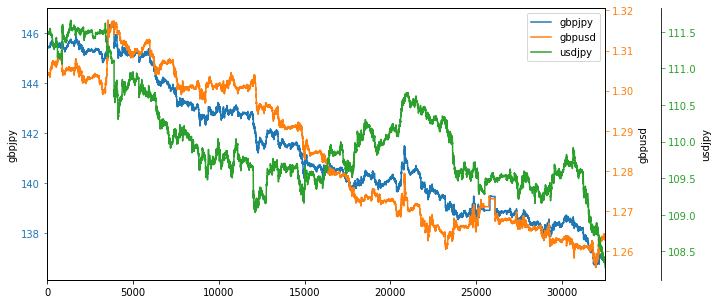

In [39]:
plot_multi(X_close, figsize=(10, 5))

# 3. Data set `X` is ready

## 3.1 Take a look

In [40]:
X.shape

(97554, 3)

In [41]:
X.sample(5)

,timestamp,ccy,close
57829,2019-05-24 13:53:00,gbpusd,1.27171
23283,2019-05-23 04:05:00,gbpjpy,139.07700
85714,2019-05-21 08:40:00,usdjpy,110.53800
97285,2019-05-31 12:30:00,usdjpy,108.55500
53095,2019-05-21 06:59:00,gbpusd,1.26955


In [42]:
X[X.ccy=='gbpusd'].head(5)

,timestamp,ccy,close
32518,2019-05-01 00:01:00,gbpusd,1.30428
32519,2019-05-01 00:02:00,gbpusd,1.30439
32520,2019-05-01 00:03:00,gbpusd,1.30437
32521,2019-05-01 00:04:00,gbpusd,1.30428
32522,2019-05-01 00:05:00,gbpusd,1.30430


## 3.2 Make an observation matrix $\mathbf{H}_k$

#### We take logs here.

In [322]:
close_dict = dict()
for ccy in ccy_list:
    close_dict[ccy] = np.log(X[X.ccy==ccy].close).reset_index(drop=True)
Z_df = pd.DataFrame(close_dict)
Z = np.array(Z_df)

In [323]:
Z_df.head()

,gbpjpy,gbpusd,usdjpy
0,4.979839,0.265651,4.713917
1,4.979936,0.265735,4.713926
2,4.979894,0.265720,4.713926
3,4.979853,0.265651,4.713926
4,4.979832,0.265666,4.713917


In [324]:
Z.shape

(25739, 3)

## Split: Training set and Validation set(=evaluation set)
- Training set `X_train`: The first two and a half weeks (From May 1, 2019 to May 19, 2019)
- Validation set `X_val`: The following one week (From May 20, 2019 to May 26, 2019)
- Test set `X_test`: The rest of days (From May 27, 2019 to May 31, 2019)
  - In fact, we never create `X_test` until the very last moment.

In [43]:
X_train = X[(X.timestamp >= pd.datetime(2019, 5, 1)) &
            (X.timestamp < pd.datetime(2019, 5, 20))]
X_val = X[(X.timestamp >= pd.datetime(2019, 5, 20)) &
          (X.timestamp < pd.datetime(2019, 5, 27))]

In [44]:
X.drop(X[(X.timestamp >= pd.datetime(2019, 5, 27)) & (
    X.timestamp < pd.datetime(2019, 6, 1))].index, inplace=True)

In [45]:
X.tail()

,timestamp,ccy,close
90770,2019-05-26 23:55:00,usdjpy,109.457
90771,2019-05-26 23:56:00,usdjpy,109.458
90772,2019-05-26 23:57:00,usdjpy,109.457
90773,2019-05-26 23:58:00,usdjpy,109.452
90774,2019-05-26 23:59:00,usdjpy,109.447


## 3.2 Save to csv files

In [46]:
X_train.to_csv('../dataset/toy_X_train.csv', index=False)
X_val.to_csv('../dataset/toy_X_val.csv', index=False)

### The end of preprocessing ------------------------------------------------

# Adaptive Kalman Filter

# 1. Import packages

In [47]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# 2. Setup

- $x$ is hidden states, i.e., intrinsic values of currencies.
- $z$ is measurements, i.e., FX rates of currency pairs. It's a 3-dimension observation because we have three currency pairs.
- The order of measurements is assumed to be GBPJPY, GBPUSD, USDJPY
- The order of latent variables is GBP, JPY, USD

## 2.1 Set variables

In [560]:
var_P = 0.001**2
var_R = 0.0003**2      # The measurement noise. 
var_Q = 0.005**2      # Variance for Q (white noise)

# time step in whatever units your filter is using for time.
# i.e. the amount of time between innovations
dt = 1

F = np.array([[1,  1,  0],
              [0,  1,  1],
              [0,  0,  1]])

H = np.array([[1,0,0],
              [0,0,0],
              [0,0,0]])

## 2.2 Define a KF function

In [657]:
def make_cv_filter(X0, F, H, dim_x=3, dim_z=3, dt=1, var_P=0.0001**2, var_R=0.0003**2, var_Q=0.0001**2):
    cvfilter = KalmanFilter(dim_x=dim_x, dim_z=dim_z)
    cvfilter.x = np.array(X0)

    # The covariance matrix, which already contains np.eye(dim_x),
    # so just multiply by the uncertainty.
    cvfilter.P *= var_P

    # The measurement noise.
    cvfilter.R *= var_R

    # The state transition matrix
    cvfilter.F = F

    # The measurement function
    cvfilter.H = H
    
    # Tje covariance matrix for hidden states `x`
    cvfilter.Q = Q_discrete_white_noise(dim=dim_x, dt=1, var=var_Q)

    return cvfilter

In [658]:
kf = make_cv_filter(X0=Z[0,:], F=F, H=H, dim_x=3, dim_z=3, dt=1,
                    var_P=var_P, var_R=var_R, var_Q=var_Q)

## 2.3 See how it goes

In [659]:
from numpy.linalg import inv

In [660]:
test_sz=100
test_z = Z[:test_sz, :]
test_gbpjpy = Z[:test_sz, 0]
test_gbpusd = Z[:test_sz, 1]
test_usdjpy = Z[:test_sz, 2]
t = np.arange(0, len(test_gbpjpy), dt)

In [663]:
Q_scale_factor = 10.
eps_max = 2
x_gbpjpy, x_gbpusd, x_usdjpy = [], [], []
epss = []

count = 0
for z in test_z:
    kf.predict()
    kf.update([z])
    y, S = kf.y, kf.S
    eps = np.dot(y.T, inv(S)).dot(y)
    epss.append(eps)
    x_gbpjpy.append(kf.x[0])
    x_gbpusd.append(kf.x[1])
    x_usdjpy.append(kf.x[2])
    
    if eps > eps_max:
        kf.Q *= Q_scale_factor
        count += 1
    elif count > 0:
        kf.Q /= Q_scale_factor
        count -= 1

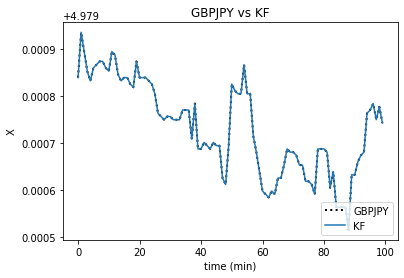

In [683]:
# plot_track(test_gbpjpy, dt=dt, label='GBPJPY')
# plot_measurements(test_gbpjpy, dt=dt, label='GBPJPY', alpha=0.5)
plot_track(test_gbpjpy,dt=dt, label='GBPJPY')
plot_filter(t, x_gbpjpy, dt=dt, label='KF')
set_labels(title='GBPJPY vs KF', x='time (min)', y='X');
plt.legend(loc=4);

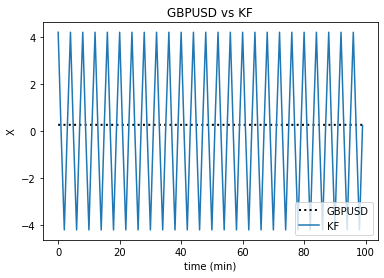

In [681]:
plot_track(test_gbpusd, dt=dt, label='GBPUSD')
plot_filter(t, x_gbpusd, dt=dt, label='KF')
set_labels(title='GBPUSD vs KF', x='time (min)', y='X');
plt.legend(loc=4);

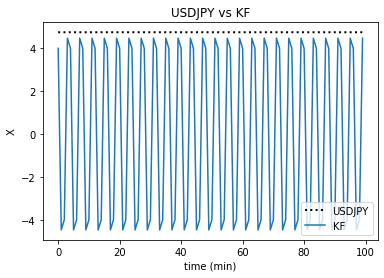

In [682]:
plot_track(test_usdjpy, dt=dt, label='USDJPY')
plot_filter(t, x_usdjpy, dt=dt, label='KF')
set_labels(title='USDJPY vs KF', x='time (min)', y='X');
plt.legend(loc=4);

In [49]:
from math import sin, cos, radians

def angle_between(x, y):
    return min(y-x, y-x+360, y-x-360, key=abs)

class ManeuveringTarget(object): 
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading
        
        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0
        
        
    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy
        
        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta
        return (self.x, self.y)
        

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, 
                                       self.hdg) / steps
        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0
            
            
    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps
        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0

In [50]:
from numpy.random import randn

class NoisySensor(object):
    def __init__(self, std_noise=1.):
        self.std = std_noise

    def sense(self, pos):
        """Pass in actual position as tuple (x, y).       
        Returns position with noise added (x,y)"""
        
        return (pos[0] + (randn() * self.std), 
                pos[1] + (randn() * self.std))

In [668]:
def plot_measurements(xs, ys=None, dt=None, color='k', lw=1, label='Measurements',
                      lines=False, **kwargs):
    """ Helper function to give a consistant way to display
    measurements in the book.
    """
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)

    plt.autoscale(tight=True)
    if lines:
        if ys is not None:
            return plt.plot(xs, ys, color=color, lw=lw, ls='--', label=label, **kwargs)
        else:
            return plt.plot(xs, color=color, lw=lw, ls='--', label=label, **kwargs)
    else:
        if ys is not None:
            return plt.scatter(xs, ys, edgecolor=color, facecolor='none',
                               lw=2, label=label, **kwargs),
        else:
            return plt.scatter(range(len(xs)), xs, edgecolor=color, facecolor='none',
                               lw=2, label=label, **kwargs),

def plot_track(xs, ys=None, dt=None, label='Track', c='k', lw=2, **kwargs):
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)
    if ys is not None:
        return plt.plot(xs, ys, color=c, lw=lw, ls=':', label=label, **kwargs)
    else:
        return plt.plot(xs, color=c, lw=lw, ls=':', label=label, **kwargs)
    
def plot_filter(xs, ys=None, dt=None, c='C0', label='Filter', var=None, **kwargs):
    """ plot result of KF with color `c`, optionally displaying the variance
    of `xs`. Returns the list of lines generated by plt.plot()"""
 
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys) * dt, dt)
    if ys is None:
        ys = xs
        xs = range(len(ys))

    lines = plt.plot(xs, ys, color=c, label=label, **kwargs)
    if var is None:
        return lines

    var = np.asarray(var)
    std = np.sqrt(var)
    std_top = ys+std
    std_btm = ys-std

    plt.plot(xs, ys+std, linestyle=':', color='k', lw=2)
    plt.plot(xs, ys-std, linestyle=':', color='k', lw=2)
    plt.fill_between(xs, std_btm, std_top,
                     facecolor='yellow', alpha=0.2)

    return lines


def set_labels(title=None, x=None, y=None):
    """ helps make code in book shorter. Optional set title, xlabel and ylabel
    """
    if x is not None:
        plt.xlabel(x)
    if y is not None:
        plt.ylabel(y)
    if title is not None:
        plt.title(title)

In [669]:
pos = list(zip([1,2,3], [0.5,0.7,0.9]))

In [670]:
np.array(pos)

array([[1. , 0.5],
       [2. , 0.7],
       [3. , 0.9]])

In [671]:
np.array([p for p in pos])

array([[1. , 0.5],
       [2. , 0.7],
       [3. , 0.9]])

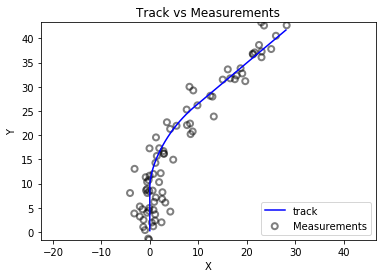

In [672]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs

sensor_std = 2.
track, zs = generate_data(50, sensor_std)
plt.figure()
plot_measurements(*zip(*zs), alpha=0.5)
plt.plot(*zip(*track), color='b', label='track')
plt.axis('equal')
plt.legend(loc=4)
set_labels(title='Track vs Measurements', x='X', y='Y')

In [673]:
tmp_F = np.array([[1, 0.1], [0, 1]])
tmp_H = np.array([[1, 0]])
cvfilter = make_cv_filter(X0=[0, 0], dt=0.1, dim_x=2, dim_z=1, F=tmp_F,
                          H=tmp_H, var_R=np.sqrt(2), var_P=np.sqrt(3), var_Q=0.02)

track, zs = generate_data(50, sensor_std)

# run it
# z_xs = zs[:, 0]
z_xs = zs[:, 0]
kxs, _, _, _ = cvfilter.batch_filter(z_xs)

In [651]:
zs

array([[-1.51189860e+00, -1.06034044e+00],
       [ 4.45370600e+00,  1.33791553e+00],
       [-3.16853129e+00,  2.48213817e+00],
       [ 1.10863154e-02, -8.00882939e-01],
       [ 3.98911250e+00,  4.66297185e+00],
       [ 4.18348594e+00, -4.94963928e-01],
       [ 1.46031482e+00,  4.08877205e+00],
       [ 8.93473848e-01,  4.31367619e+00],
       [ 4.59684975e-03,  1.27279700e+00],
       [ 2.18736426e+00,  4.49745189e+00],
       [-2.45882274e+00,  3.85148203e+00],
       [-3.24532887e-01,  8.28612464e-01],
       [-4.23944456e-01,  3.61129767e+00],
       [ 4.29570142e+00,  4.07398794e+00],
       [-1.91779519e-01,  6.73783326e+00],
       [ 3.45545891e+00,  3.35369937e+00],
       [ 4.11522028e+00,  1.02948830e+01],
       [-1.02520368e+00,  2.56421718e+00],
       [-9.76261983e-01,  7.20201721e+00],
       [-4.19512570e-01,  6.73965989e+00],
       [ 2.18835048e+00,  4.94132650e+00],
       [-8.36571457e-01,  6.61567736e+00],
       [-5.08848007e-01,  6.32150198e+00],
       [-1.

In [268]:
z_xs.shape

(80,)

In [269]:
z_xs

array([-2.1618124 ,  0.06125867,  2.50844616,  1.85486334, -0.33704714,
       -1.17124823, -0.10959044,  0.32359963, -0.51735666, -1.76213698,
       -0.14435278, -0.13759877, -1.33016007,  1.68339673,  1.41205981,
       -2.67827925, -2.61640203,  0.39599183, -2.26160608,  0.11988057,
       -0.38435378,  2.10274533,  1.36760084, -2.13163222, -2.09964164,
        2.5129003 , -0.13906796, -2.08766972, -0.90371418,  1.84072408,
       -2.3214703 ,  1.20083013, -2.74269239,  1.05379687, -0.26447152,
        3.528613  , -0.75101745,  1.05901797, -0.14109882, -1.16308628,
        3.75725727, -2.4795098 ,  0.53798149, -0.64656202,  5.15739125,
        1.85712042,  3.93966717,  3.97329717, 10.32764662,  2.29483221,
        7.49970239,  4.01002778,  9.1944478 , 10.50408267, 10.09007403,
       12.01433386, 12.65443671, 12.7986411 , 13.18186283, 14.06193905,
       12.92041272, 14.2066489 , 15.53860983, 13.87436238, 14.5255703 ,
       17.25251754, 17.13997222, 17.31022875, 17.5391254 , 23.50

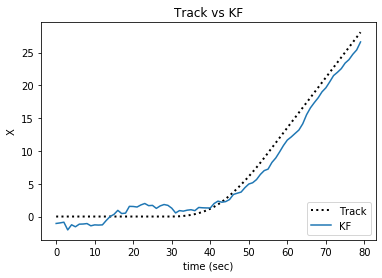

In [264]:
plot_track(track[:, 0], dt=dt)
plot_filter(kxs[:, 0], dt=dt, label='KF')
set_labels(title='Track vs KF', x='time (sec)', y='X');
plt.legend(loc=4);